# Utilities Analysis

In [1]:
import numpy as np
import pandas as pd
from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns 

set_config(display="diagram")
pd.set_option('display.max_rows', None)
color_pal = sns.color_palette()


In [2]:
data = pd.read_excel("datasets/em_housemeterreadings.xlsx")
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns \n")
print(f"There values are {data.info()}")   

There are 57667 rows and 21 columns 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57667 entries, 0 to 57666
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             57667 non-null  int64         
 1   paymenttermid  57667 non-null  int64         
 2   houseid        57667 non-null  int64         
 3   meterid        57614 non-null  float64       
 4   reading        57667 non-null  float64       
 5   quantity       57667 non-null  float64       
 6   cost           2136 non-null   float64       
 7   amount         2136 non-null   float64       
 8   month          57667 non-null  int64         
 9   year           57667 non-null  int64         
 10  image          57278 non-null  object        
 11  status         57667 non-null  int64         
 12  remarks        0 non-null      float64       
 13  ipaddress      0 non-null      float64       
 14  createdby      837 non-null    f

## Data Cleaning

The columns are their definations:

* `id` - unique identifier of each meter reading
* `paymenttermid`- Utility represented by reading

```
    {
        "7": "Gas",
        "11" : "Backup Power"
        "36" : "Water",
        "37" : "Electricity",
        "38" : "Gas Residential",
        "39" : "Gas Commercial", 
        "40" : "Backup Power (CPF)",
        "41" : "Water (CPF)",
        "42" : "Electricity (CPF)",
    }
```

* `houseid` - House the reading came from 
* `meterid` - Meter id the reading was read from 
* `reading` - The reading
* `quantity` - Quantity the reading represents
* `cost` - The cost( column is empty)
* `amount` - The amount to be paid ( column is empty) 
* `month` - The month the reading was taken value are number i.e 1,2,3,
* `year` - The year the reading was made
* `image` - image of reading
* `status`  - Whether the billing was used for billing or not. 
* `remarks` - Remarks  on meter reading (empty)
* `ipaddress` - (empty)
* `createdby` - Who created meter reading row 
* `createdon` - When the meter reading row was created
* `lasteditedby` - Who last edited the meter reading row
* `lasteditedon` = When the meter reading row was last edited
* `archive` - Has the row been archived

#### Remarks 

We intend to use the dataset to build a model to predict utilities quantity.
The mdoel will be built using `payemnttermid`, `meterid`, `reading`, `quantity`, `month`, `year`, `status` for this analysis. 
The target variables is the `reading`. 

In [3]:
result = data[['reading', 'quantity', 'year', 'month']][data['reading'].ne(data['quantity'])]
print((data.reading == data.quantity).all())
print(len(result))

False
1361


In [4]:
columns = ['paymenttermid', 'meterid', 'reading', 'quantity', 'month', 'year', 'status']
data = data[columns]

In [5]:
data.isna().sum()

paymenttermid     0
meterid          53
reading           0
quantity          0
month             0
year              0
status            0
dtype: int64

In [6]:
empty = data[data.isna().any(axis=1)]
empty.shape

(53, 7)

There are 53 rows that contain a missing value. The missing values are in the meterid column. We are going to exclude these rows for modelling because there are a small number. 


In [7]:
data = data.dropna()
data.isna().sum()

paymenttermid    0
meterid          0
reading          0
quantity         0
month            0
year             0
status           0
dtype: int64


Some columns are categorical in nature but their data types is either float or integer. We will have to fix their data type so as not to confuse our model during training.

These columns are `paymentid`, `houseid`, `meterid`, `status`.
There also columns that should be in datetime format. They are `year`, `month`

In [8]:
data['month'].value_counts()

12    5023
8     4956
10    4956
11    4953
7     4926
9     4922
4     4907
6     4879
5     4839
2     4812
3     4614
1     3826
0        1
Name: month, dtype: int64

There is a row containing 0 month which is impossible

In [9]:
data[data['month'] == 0]

,paymenttermid,meterid,reading,quantity,month,year,status
15320,0,0.0,0.0,0.0,0,0,0


In [10]:
data = data.drop(data[data['month'] == 0].index)

In [11]:
# target = data['reading']
# data = data.drop(columns=['reading'])
# print(f"""
#     The feature rows are {data.columns} and they contain {data.shape[0]} rows \n
#     The target rows is {target.name} and it contains {target.shape[0]} rows 
#     """
#      ) 

We are going to convert each row to the right data type for easier analysis.

In [12]:
data[["paymenttermid", "meterid", "status"]] = data[["paymenttermid", "meterid", "status"]].astype("category")
data["month"] = data["month"].astype(str)
data["year"] = data["year"].astype(str)
data["yearmonth"] = pd.to_datetime(data["year"] + ' ' + data["month"])

data = data.set_index('yearmonth')
data.sort_index(inplace=True)

data["year"] = data.index.year
data["month"] = data.index.month
data.head()

,paymenttermid,meterid,reading,quantity,month,year,status
yearmonth,,,,,,,
2019-01-01,36,162.0,3.0,3.0,1,2019,1
2019-01-01,7,315.0,103.0,103.0,1,2019,1
2019-01-01,7,481.0,103.0,103.0,1,2019,1
2019-01-01,7,393.0,104.0,104.0,1,2019,1
2019-01-01,7,499.0,103.0,103.0,1,2019,1


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57613 entries, 2019-01-01 to 2023-01-01
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   paymenttermid  57613 non-null  category
 1   meterid        57613 non-null  category
 2   reading        57613 non-null  float64 
 3   quantity       57613 non-null  float64 
 4   month          57613 non-null  int64   
 5   year           57613 non-null  int64   
 6   status         57613 non-null  category
dtypes: category(3), float64(2), int64(2)
memory usage: 2.5 MB


## Data Exploration
The reading represent different utilities we will separate the utilities in the exploration.

The distribution of utilities are 
* Electricity - 16081
* Backup Power - 14989
* Water - 13622
* Gas - 12209
* Electricity (CPF) - 332
* Water (CPF) - 207
* Backup Power (CPF) - 171
* Gas Residential - 0
* Gas Commercial - 0

In [14]:
data['paymenttermid'].value_counts()

37    16081
11    14989
36    13622
7     12209
42      332
41      207
40      171
43        2
Name: paymenttermid, dtype: int64

For this analysis, we are going to combine the 
- [x] Electricity and electiry(cpf)
- [x] Backup power and backup power (cpf) 
- [x] Water and water (cpf)

In [15]:
gas_data = data.query("paymenttermid == 7")
electricity_data = data.query("paymenttermid == 37 | paymenttermid == 42")
backuppower_data = data.query("paymenttermid == 11 | paymenttermid == 40")
water_data = data.query("paymenttermid == 36 | paymenttermid == 41")

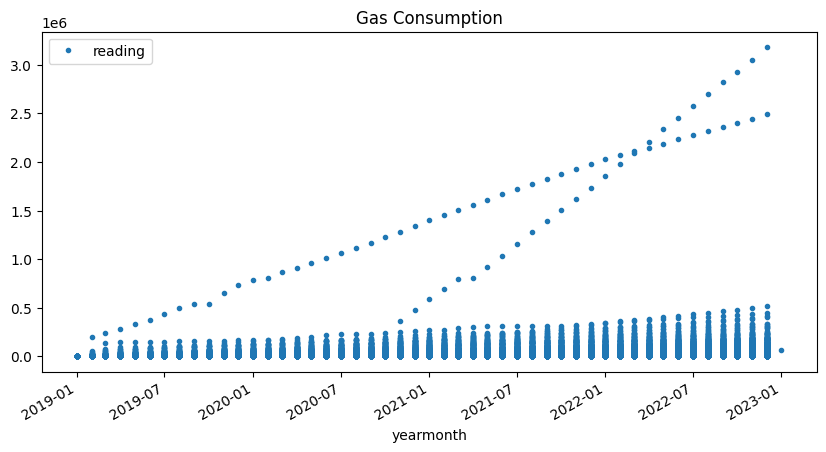

In [16]:
gas_data.plot(
    y='reading',
    style='.',
        figsize=(10, 5),
        color=color_pal[0],
        title='Gas Consumption')
plt.show()

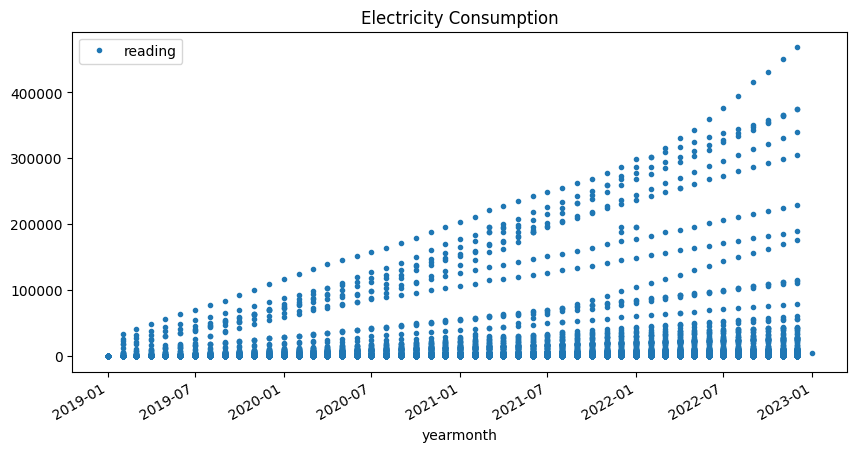

In [17]:
electricity_data.plot(
    y='reading',
    style='.',
        figsize=(10, 5),
        color=color_pal[0],
        title='Electricity Consumption')
plt.show()

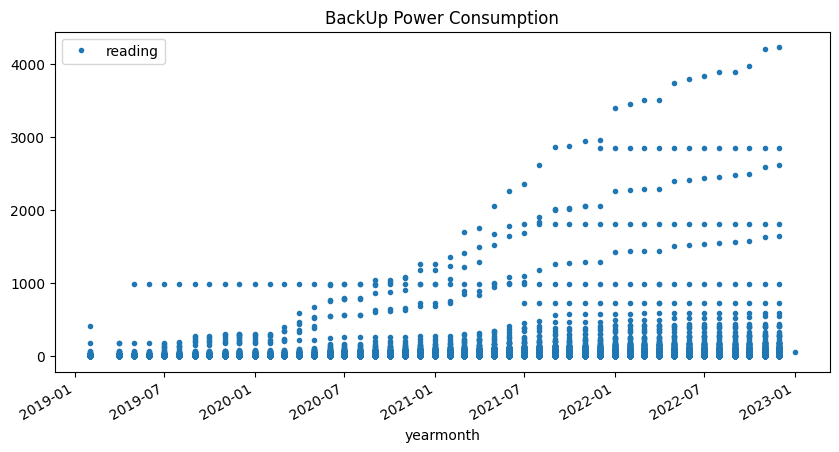

In [18]:
backuppower_data.plot(
    y='reading',
    style='.',
        figsize=(10, 5),
        color=color_pal[0],
        title='BackUp Power Consumption')
plt.show()

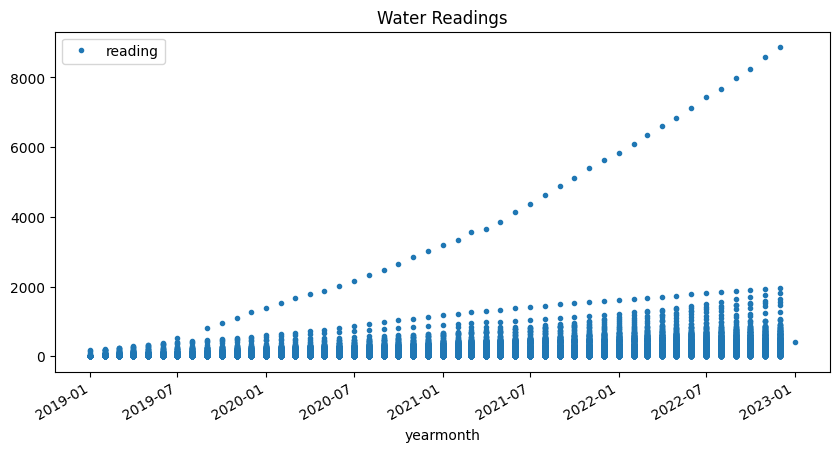

In [19]:
water_data.plot(
    y='reading',
    style='.',
        figsize=(10, 5),
        color=color_pal[0],
        title='Water Readings')
plt.show()

There reading have a wide range of values. A source of the wide range value may be due to the some reading represent multiple houses. We will have to scale the data to improve our model performance.

## Train Test Split

In [20]:
print(f"The water data has {water_data.shape[0]} rows \n")
print(f"The backup power data has {backuppower_data.shape[0]} rows \n")
print(f"The electricity data has {electricity_data.shape[0]} rows \n")
print(f"The gas data has {gas_data.shape[0]} rows \n")

The water data has 13829 rows 

The backup power data has 15160 rows 

The electricity data has 16413 rows 

The gas data has 12209 rows 



In [21]:
gas_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12209 entries, 2019-01-01 to 2023-01-01
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   paymenttermid  12209 non-null  category
 1   meterid        12209 non-null  category
 2   reading        12209 non-null  float64 
 3   quantity       12209 non-null  float64 
 4   month          12209 non-null  int64   
 5   year           12209 non-null  int64   
 6   status         12209 non-null  category
dtypes: category(3), float64(2), int64(2)
memory usage: 567.0 KB


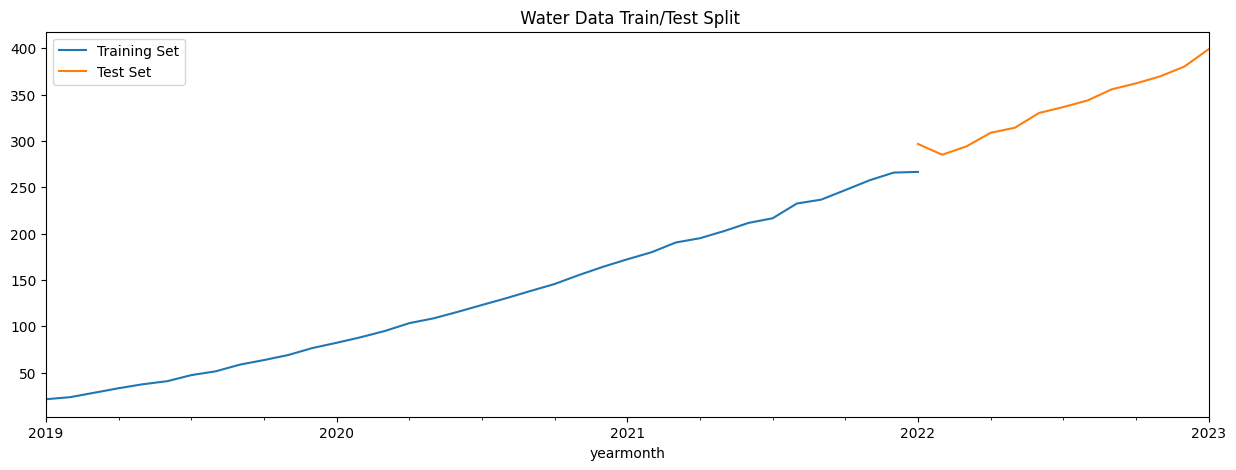

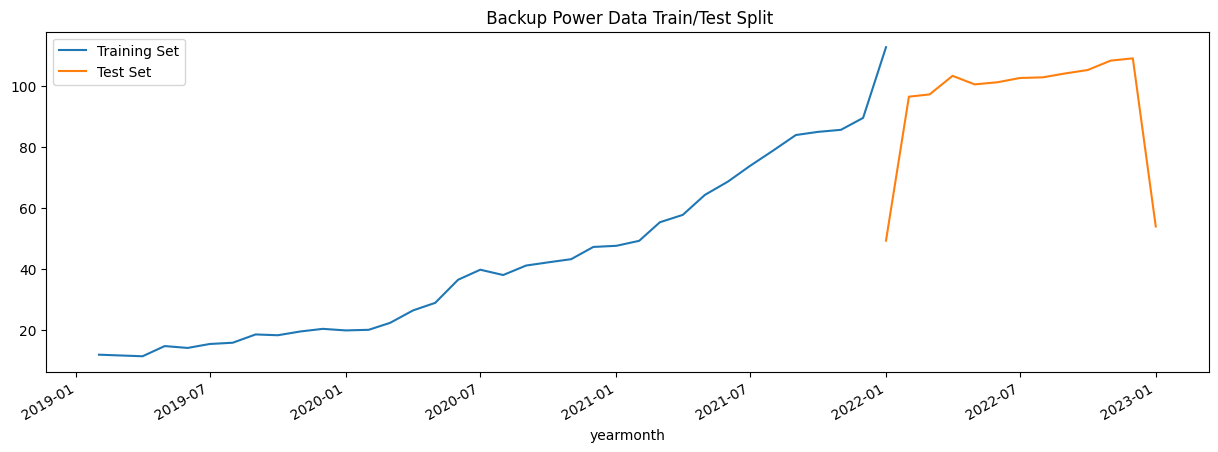

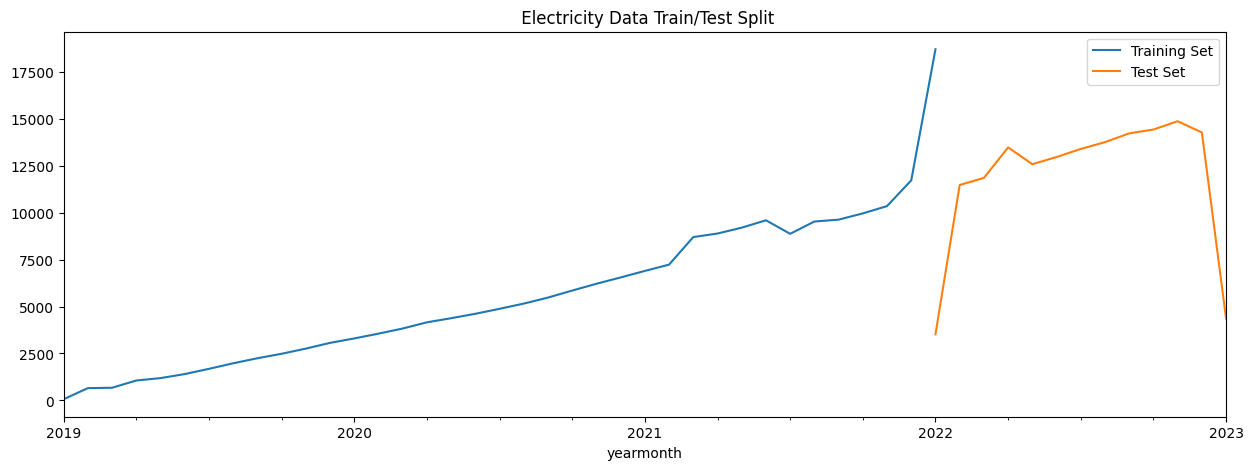

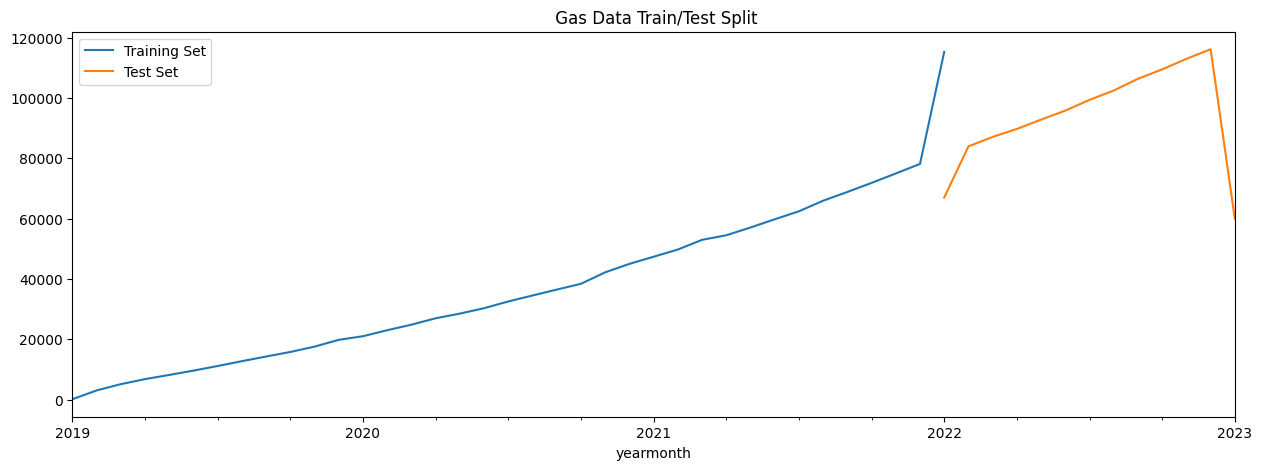

In [22]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3)

# train-test split for the water data
X_water = water_data.drop(labels=['reading'], axis=1)
y_water = water_data['reading']

for train_index, test_index in tss.split(X_water):
    X_water_train, X_water_test = X_water.iloc[train_index,:], X_water.iloc[test_index,:]
    y_water_train, y_water_test = y_water.iloc[train_index], y_water.iloc[test_index]

fig, ax = plt.subplots(figsize=(15, 5))
y_water_train.groupby('yearmonth').mean().plot(ax=ax, label="Training Set", title=" Water Data Train/Test Split")
y_water_test.groupby('yearmonth').mean().plot(ax=ax, label="Test Set")
                                              
ax.legend(['Training Set', 'Test Set'])
plt.show()

# train-test split for backup power data
X_backuppower = backuppower_data.drop(labels=['reading'], axis=1)
y_backuppower = backuppower_data['reading']

for train_index, test_index in tss.split(X_backuppower):
    X_backuppower_train, X_backuppower_test = X_backuppower.iloc[train_index,:], X_backuppower.iloc[test_index,:]
    y_backuppower_train, y_backuppower_test = y_backuppower.iloc[train_index], y_backuppower.iloc[test_index]

fig, ax = plt.subplots(figsize=(15, 5))
y_backuppower_train.groupby('yearmonth').mean().plot(ax=ax, label="Training Set", title=" Backup Power Data Train/Test Split")
y_backuppower_test.groupby('yearmonth').mean().plot(ax=ax, label="Test Set")
                                              
ax.legend(['Training Set', 'Test Set'])
plt.show()

X_electricity = electricity_data.drop(labels=['reading'], axis=1)
y_electricity = electricity_data['reading']

for train_index, test_index in tss.split(X_electricity):
    X_electricity_train, X_electricity_test = X_electricity.iloc[train_index,:], X_electricity.iloc[test_index,:]
    y_electricity_train, y_electricity_test = y_electricity.iloc[train_index], y_electricity.iloc[test_index]

fig, ax = plt.subplots(figsize=(15, 5))
y_electricity_train.groupby('yearmonth').mean().plot(ax=ax, label="Training Set", title=" Electricity Data Train/Test Split")
y_electricity_test.groupby('yearmonth').mean().plot(ax=ax, label="Test Set")
                                              
ax.legend(['Training Set', 'Test Set'])
plt.show()

X_gas = gas_data.drop(labels=['reading'], axis=1)
y_gas = gas_data['reading']

for train_index, test_index in tss.split(X_gas):
    X_gas_train, X_gas_test = X_gas.iloc[train_index,:], X_gas.iloc[test_index,:]
    y_gas_train, y_gas_test = y_gas.iloc[train_index], y_gas.iloc[test_index]

fig, ax = plt.subplots(figsize=(15, 5))
y_gas_train.groupby('yearmonth').mean().plot(ax=ax, label="Training Set", title=" Gas Data Train/Test Split")
y_gas_test.groupby('yearmonth').mean().plot(ax=ax, label="Test Set")
                                              
ax.legend(['Training Set', 'Test Set'])
plt.show()



## Modelling



In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV


In [44]:
preprocessor = ColumnTransformer([
    ('scaling', StandardScaler(), ['quantity',])
])

linear_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RidgeCV())
])

linear_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                                  ['quantity'])])),
                ('regressor', RidgeCV())])

In [58]:
gb_model = Pipeline([
    ("regressor", HistGradientBoostingRegressor())
])
hgbdt_model

Pipeline(steps=[('regresssor',
                 HistGradientBoostingRegressor(max_leaf_nodes=4,
                                               random_state=42))])

### Hyperparameter Tuning

#### Ridge Cross Validation

In [79]:
param_distributions = {'regressor__alphas': np.logspace(-5, 5, 15),
                      'regressor__fit_intercept': [True, False],
                      }

random_search = RandomizedSearchCV(
    linear_model, 
    param_distributions=param_distributions, 
    n_iter=20, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1, cv=TimeSeriesSplit(n_splits=4), random_state=42)


In [80]:
random_search.fit(X_water_train, y_water_train)

# Print the best parameters and the best score
print("Best parameters: ", random_search.best_params_)
print("Best MAE: ", -random_search.best_score_)

Best parameters:  {'regressor__fit_intercept': True, 'regressor__alphas': 5.1794746792312125e-05}
Best MAE:  2.3582209395168556


In [83]:
mae = random_search.score(X_water_test, y_water_test)
print(f"The test mean absolue error of the best model is"
      f": {-mae:.3f}")

The test mean absolue error of the best model is: 2.428


#### HistGradientBoostingRegressor

In [59]:
from scipy.stats import loguniform 

class loguniform_int: 
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b): 
        self._distribution = loguniform(a, b)
        
    def rvs(self, *args, **kwargs): 
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [84]:
%%time

param_distributions = {
    'regressor__l2_regularization': loguniform(1e-6, 1e3),
    'regressor__learning_rate': loguniform(0.001, 10),
    'regressor__max_leaf_nodes': loguniform_int(2, 256),
    'regressor__min_samples_leaf': loguniform_int(1, 100),
    'regressor__max_bins': loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    gb_model, param_distributions=param_distributions, n_iter=10, cv=TimeSeriesSplit(n_splits=4), verbose=1, random_state=42, scoring='neg_mean_absolute_error'
)
model_random_search.fit(X_water_train, y_water_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
CPU times: total: 52.5 s
Wall time: 26.5 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=Pipeline(steps=[('regressor',
                                              HistGradientBoostingRegressor())]),
                   param_distributions={'regressor__l2_regularization': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BA41B47FA0>,
                                        'regressor__learning_rate': <scipy.stats._distn_inf...ture.rv_continuous_frozen object at 0x000001BA41B46B30>,
                                        'regressor__max_bins': <__main__.loguniform_int object at 0x000001BA41BB2E60>,
                                        'regressor__max_leaf_nodes': <__main__.loguniform_int object at 0x000001BA41BB2DA0>,
                                        'regressor__min_samples_leaf': <__main__.loguniform_int object at 0x000001BA41BB3850>},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [86]:
mae = model_random_search.score(X_water_test, y_water_test)
print(f"The test mean absolue error of the best model is"
      f": {-mae:.3f}")

The test mean absolue error of the best model is: 81.219


In [66]:
from pprint import pprint

print('The best parameters are:')
pprint(model_random_search.best_params_)

The best parameters are:
{'regressor__l2_regularization': 14.300998871960756,
 'regressor__learning_rate': 0.09928168914436868,
 'regressor__max_bins': 111,
 'regressor__max_leaf_nodes': 30,
 'regressor__min_samples_leaf': 70}


### Model Cross Validation

In [87]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate

lm_model = RidgeCV(fit_intercept=True)

tscv = TimeSeriesSplit(n_splits=4)
lm_cv_results = cross_validate(
    lm_model, X_water_train, y_water_train, cv=tscv, 
    scoring="neg_mean_absolute_error", 
    return_estimator=True, 
    return_train_score=True, 
    error_score='raise',
    n_jobs=-1)

In [89]:
gb_model = HistGradientBoostingRegressor(
    l2_regularization=14.301, 
    learning_rate=0.0992, 
    max_bins=111, 
    max_leaf_nodes=30, 
    min_samples_leaf=70)

hgbr_cv_results = cross_validate(
    gb_model, X_water_train, y_water_train, cv=tscv,
    scoring = "neg_mean_absolute_error",
    return_estimator=True,
    return_train_score=True,
    n_jobs=-1
)

In [90]:
lm_train_errors = -lm_cv_results["train_score"]
print(f"Linear model - MAE on train sets:\t",
      f"{lm_train_errors.mean():.3f} +/- {lm_train_errors.std():.3f} Watts")
lm_test_errors = -lm_cv_results["test_score"]
print(f"Linear model - MAE on test sets:\t",
      f"{lm_test_errors.mean():.3f} +/- {lm_test_errors.std():.3f} Watts")

hgbr_train_errors = -hgbr_cv_results["train_score"]
print(f"Histogram GBDT - MAE on train sets:\t",
      f"{hgbr_train_errors.mean():.3f} +/- {hgbr_train_errors.std():.3f} Watts")
hgbr_test_errors = -hgbr_cv_results["test_score"]
print(f"Histogram GBDT - MAE on test sets:\t",
      f"{hgbr_test_errors.mean():.3f} +/- {hgbr_test_errors.std():.3f} Watts")


Linear model - MAE on train sets:	 0.072 +/- 0.072 Watts
Linear model - MAE on test sets:	 2.413 +/- 3.956 Watts
Histogram GBDT - MAE on train sets:	 5.591 +/- 1.730 Watts
Histogram GBDT - MAE on test sets:	 24.602 +/- 8.480 Watts


In [91]:
scores = {
    "GB-test_score": -hgbr_cv_results['test_score'],
    "GB-train_score" : -hgbr_cv_results['train_score'],
    "LN-test_score" : -ln_cv_results['test_score'],
    "LN-train_score" : -ln_cv_results['train_score'],
}

scores = pd.DataFrame(scores)
scores

,GB-test_score,GB-train_score,LN-test_score,LN-train_score
0,13.543057,3.052359,0.000021,0.000018
1,21.055228,4.943871,0.148373,0.000128
2,27.106420,7.300610,0.239726,0.146729
3,36.704121,7.068355,9.262188,0.139274


### Model Selection
It seems the Ridge algorithm performs best for this dataset we will use this algorithm for our model creation.

In [99]:
from joblib import dump, load

In [102]:
water_lm = RidgeCV(fit_intercept=True)
water_lm.fit(X_water, y_water)
dump(water_lm, 'water_model.joblib')

['water_model.joblib']

In [103]:
backuppower_lm = RidgeCV(fit_intercept=True)
backuppower_lm.fit(X_backuppower, y_backuppower)
dump(backuppower_lm, 'backuppower_model.joblib')

['backuppower_model.joblib']

In [104]:
electricity_lm = RidgeCV(fit_intercept=True)
electricity_lm.fit(X_electricity, y_electricity)
dump(electricity_lm, 'electricity_model.joblib')

['electricity_model.joblib']

In [105]:
gas_lm = RidgeCV(fit_intercept=True)
gas_lm.fit(X_gas, y_gas)
dump(gas_lm, 'gas_model.joblib')

['gas_model.joblib']